<a href="https://colab.research.google.com/github/formroller/ML_clone/blob/master/kaggle/Santander/SantanderPrediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [SantanderPrediction](https://www.kaggle.com/gpreda/santander-eda-and-prediction#Data-exploration)

고객 만족도는 고객의 이탈 여부를 결정하는 척도가 된다. 현재 커널에서는 수백개의 익명화된 변수들을 사용해 은행 업무를 처리하는 동안 서비스 만족도가 낮은 고객 예측을 목적으로 한다. 커널 평가는 예측값과 관찰값 사이의 ROC curver 아래 영역을 기준으로 한다.

# 목차
1. Introduce
2. Prepare the data analysis
3. Data Exploration
 * Check the data
 * Density plots of features
 * Distribution of mean and std
 * Distribution of min and max
 * Distribution of Skew and Kurtosis
 * Feature Correlations
 * Duplicate values
4. Feature Engineering
5. Model
6. Submission

# 1.Introdution
---
이 챌린지에서 Santander 은행은 Kaggler에게 거래 금액에 관계없이 미래에 특정한 거래를 진행한 고객을 식별할 수 있도록 도움을 요청한다.   

이번 대회를 위해 제공된 데이터는 이 문제를 해결하기 위해 사용할 수 있는 실제 데이터와 동일한 구조를 지닌다. 데이터는 익명화되어 각 행에는 숫자로 식별된 200개의 숫자 값이 포함된다. 

다음에서는 데이터 탐색, 모델을 위한 준비, 모델 훈련, 테스트 세트의 목표 값 예측·제출 준비 과정을 수행한다.

# 2.Prepare for data analysis


## 2.1 Load Package

In [1]:
import os
os.chdir('/content/drive/MyDrive/kaggle/Santander')

import gc
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

In [2]:
# plot 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,597 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and d

In [3]:
%%time
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submissino=pd.read_csv('sample_submission.csv')

CPU times: user 14.1 s, sys: 1.22 s, total: 15.3 s
Wall time: 19.1 s


# 3.Data Exploration
---

## 3.1 Check the data

In [4]:
train.shape, test.shape

((200000, 202), (200000, 201))

train/test 모두 200,000개의 행과 202개, 201개의 열로 구성되어 있다.

In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


**train set이 포함한 자료**  
* ID_code(string)
* target
* 200개의 수치형 변수(var_0 - var_199)

**test set이 포함한 자료**
* ID_code(string)
* 200개의 수치형 변수(var_0 - var_199)

### 3.1.1 결측치와 데이터 타입 확인


In [60]:
def missing_data(data):
    total=data.isnull().sum()
    percent=(data.isnull().sum()/data.isnull().count()*100)
    tt=pd.concat([total,percent], axis=1, keys=['Total','Percent'])
    types=[]
    for col in data.columns:
        dtype=str(data[col].dtype)
        types.append(dtype)
    tt['Types']=types
    return(np.transpose(tt))

In [61]:
missing_data(train)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [66]:
missing_data(test)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


데이터 셋에는 결측값이 없는 것을 알 수 잇다. 다음은 수치형 변수를 확인해본다.

In [10]:
%%time
train.describe()

CPU times: user 1.89 s, sys: 142 ms, total: 2.03 s
Wall time: 2.04 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [11]:
%%time
test.describe()

CPU times: user 1.96 s, sys: 12.5 ms, total: 1.97 s
Wall time: 1.97 s


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,0.371335,-3.268551,14.022662,8.540872,7.532703,14.573704,9.321669,-5.70445,15.265776,12.456675,13.298428,17.230598,4.299010,3.019707,10.567479,13.666970,-3.983721,-1.129536,5.530656,5.047247,-7.687695,10.404920,-0.524830,14.762686,11.434861,3.870130,2.213288,5.875048,10.647806,0.672667,...,24.146181,5.635300,5.360975,11.026376,-2.857328,19.320760,2.962821,-4.189133,4.930356,5.633716,-0.020824,-0.805148,19.779528,-0.666240,20.264135,11.635715,-2.776134,11.864538,-0.949318,2.582604,-2.722636,10.080827,0.651432,8.768929,12.719302,-3.963045,8.978800,-10.291919,15.366094,0.755673,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,5.508661,5.961443,0.190071,4.628712,2.255257,0.411592,2.544860,6.74646,7.846983,7.989812,5.884245,8.199877,2.844023,0.527951,3.771047,0.285454,5.945853,1.524765,0.785618,2.610078,7.971581,2.156324,2.588700,4.325727,0.541040,5.170614,3.120685,2.257235,4.260820,4.078592,...,10.876184,0.217936,1.426064,5.268894,5.457937,5.039303,0.370668,7.827428,3.086443,0.365750,4.417876,5.378492,8.678024,5.987419,7.141816,2.884821,7.557001,2.626556,8.570314,2.803890,5.225554,1.369546,8.961936,4.464461,9.316889,4.724641,3.206635,11.562352,3.929227,0.976123,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,-22.672400,-25.811800,13.424500,-4.741300,0.670300,13.203400,0.314300,-28.90690,-11.324200,-12.699400,-2.634600,-9.940600,-5.164000,1.390600,-0.731300,12.749600,-24.536100,-6.040900,2.842500,-4.421500,-34.054800,1.309200,-8.209000,1.691100,9.776400,-16.923800,-10.466800,-0.885100,-5.368300,-14.083700,...,-8.925700,4.910600,0.106200,-6.093700,-21.514000,3.667300,1.813100,-37.176400,-5.405700,4.291500,-15.593200,-20.393600,-11.796600,-21.342800,-2.485400,2.951200,-29.838400,5.025300,-29.118500,-7.767400,-20.610600,5.346000,-28.092800,-5.476800,-17.011400,-22.467000,-2.303800,-47.306400,4.429100,-2.511500,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.91190

위를 통해 관찰할 수 있는 것은 다음과 같다.
* train/test 표준편차는 비교적으로 크다.
* train과 test 모두 최솟값, 최댓값, 평균, 분산이 꽤 유사해 보인다. 
* 평균 값의 범위가 넓게 분포해 있다. 
  
train과 test set의 수는 동일하며, 이 데이터들에 대해 몇가지 변수로 산포도를 그려본다. 

In [12]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig,ax = plt.subplots(4,4, figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show(0)

아래에서는 5%의 데이터만 표시할 것이다.  
(X축=train data, y축= test data)

<Figure size 432x288 with 0 Axes>

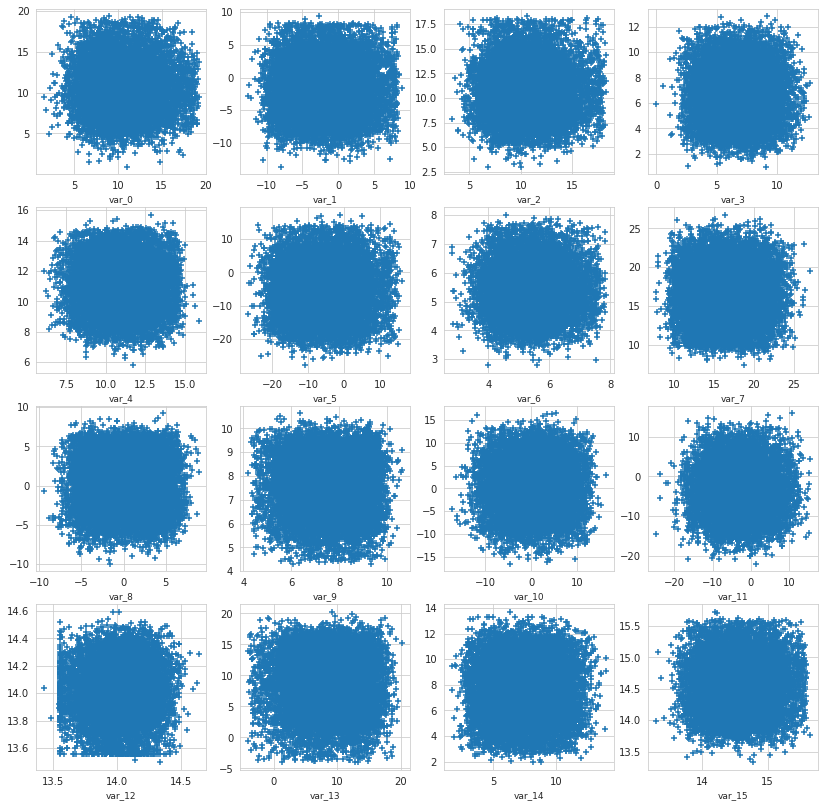

<Figure size 432x288 with 0 Axes>

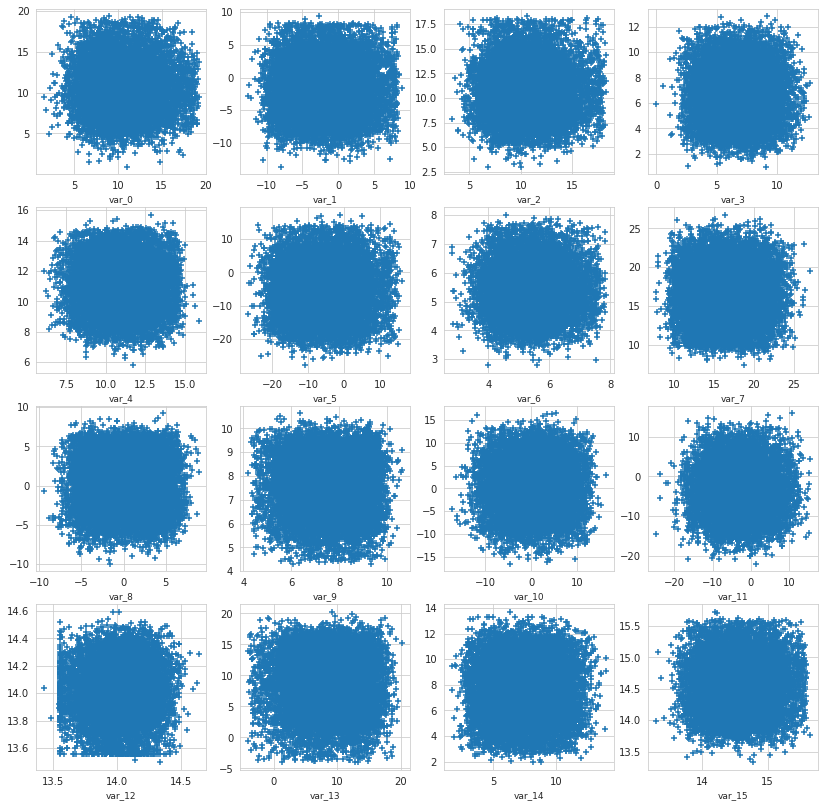

In [13]:
features = []
for i in range(0,16):
    features.append('var_'+str(i))

plot_feature_scatter(train[::20], test[::20], features)

**train**의 **Target**값의 분포를 확인해본다. 

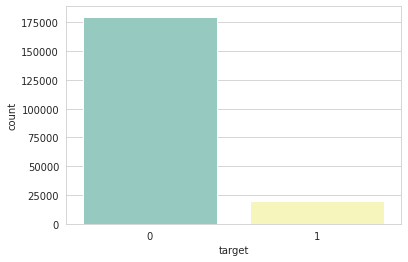

In [14]:
sns.countplot(train['target'], palette='Set3')

In [15]:
print(f"There are    {(100*train['target'].value_counts()[1]/train.shape[0]):.3f} target values with 1")

There are    10.049 target values with 1


데이터의 Target값은 불균형을 나타낸다.

## 3.2 Density plots of features
train 데이터 세트에 있는 density plot(밀도그림)을 확인해보자.  
목표값의 0과 1인 값의 분포를 다른 색으로 나타낸다.

In [16]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig,ax = plt.subplots(10, 10, figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False, label=label1)
        sns.distplot(df2[feature], hist=False, label=label2)
        plt.xlabel(feature, fontsize=9)
        loc, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

### 3.2.1 train set

처음 100개의 값 출력.(2:102)

<Figure size 432x288 with 0 Axes>

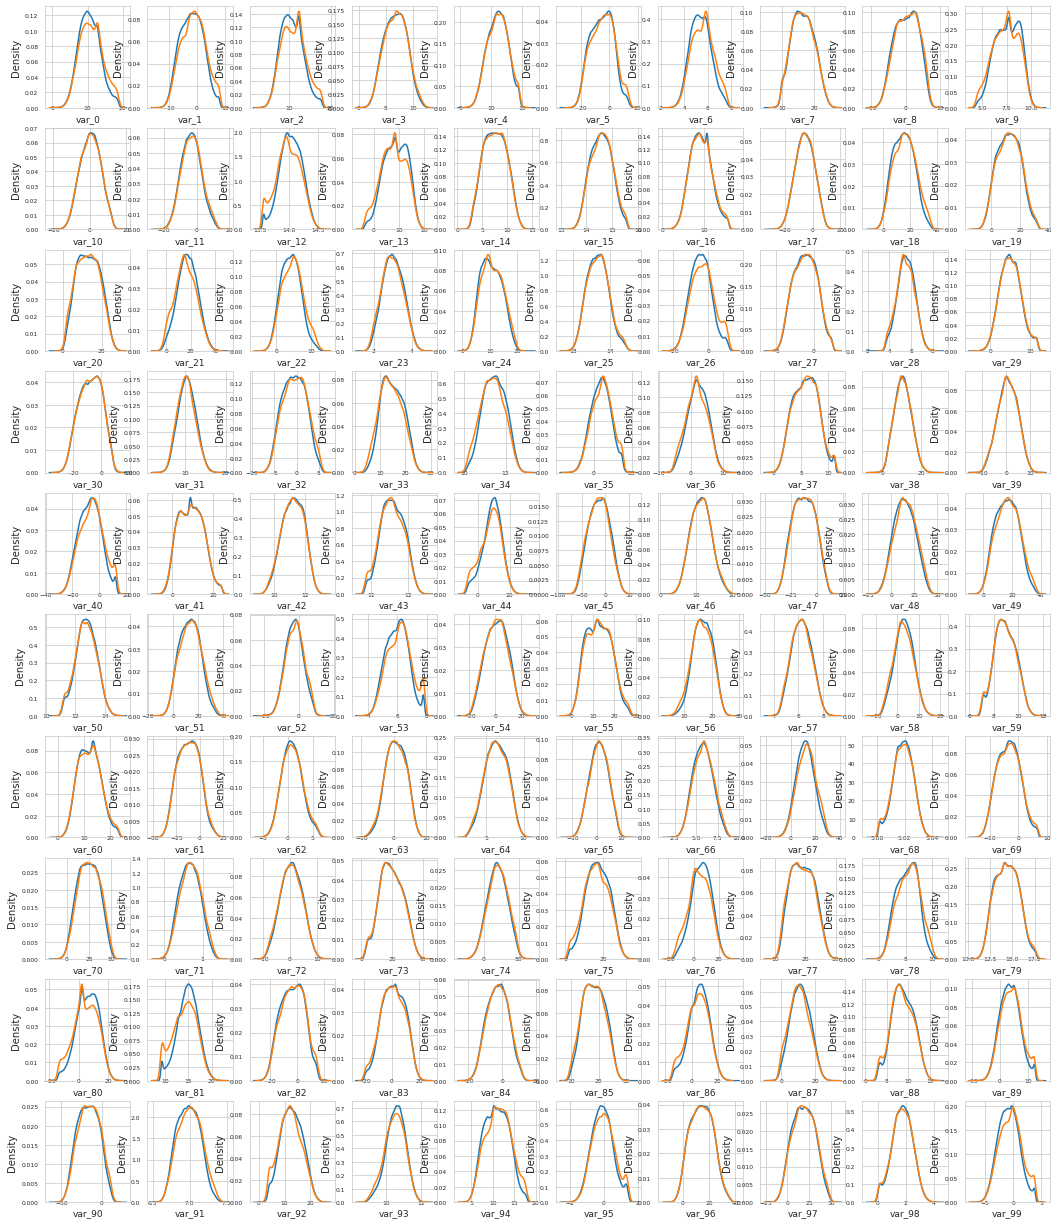

In [17]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]

features=train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

다음 100개의 값 출력.(102:202)

<Figure size 432x288 with 0 Axes>

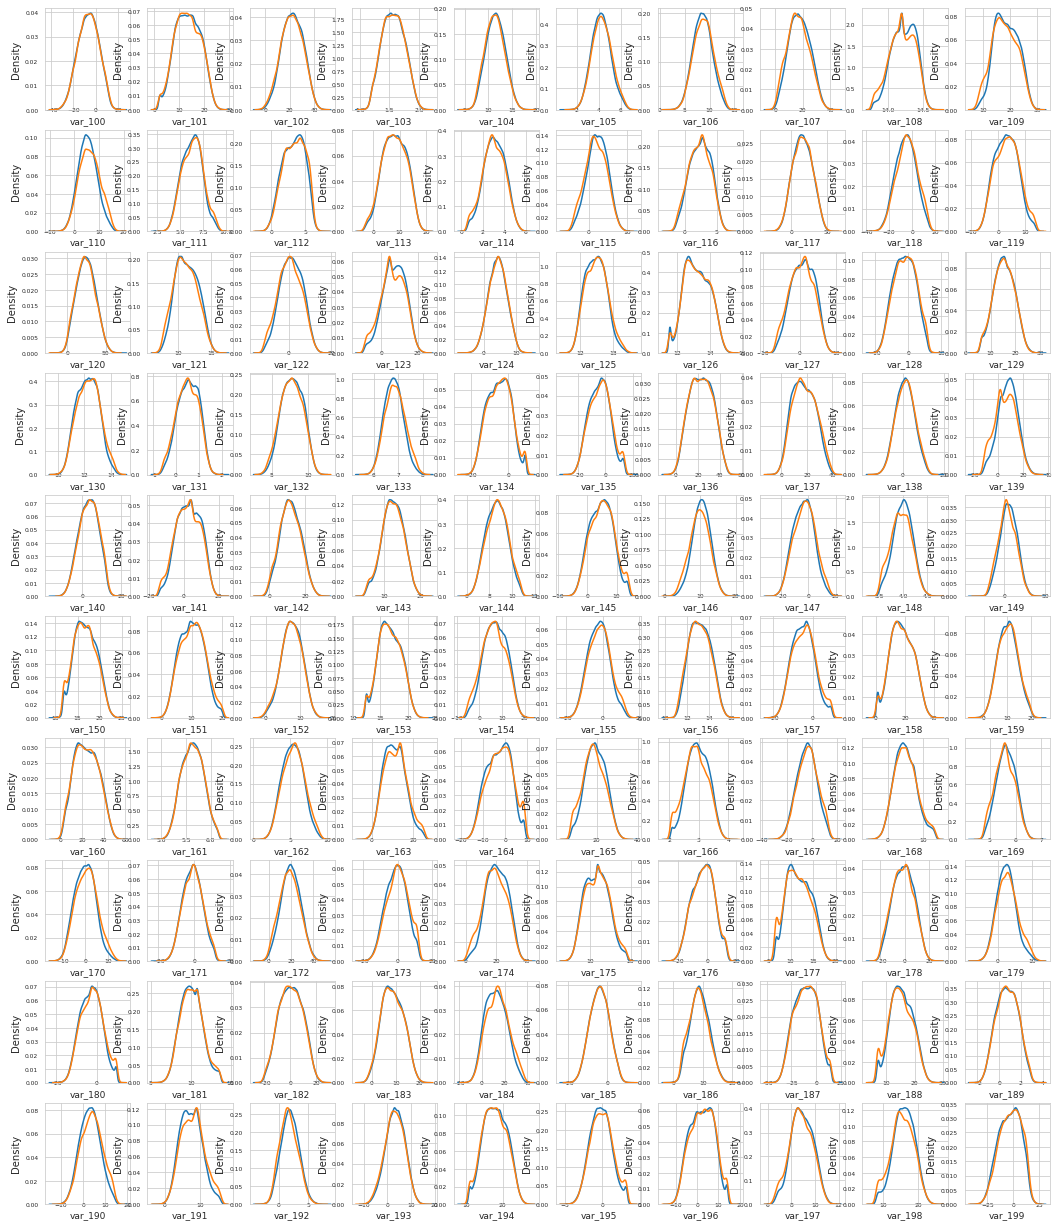

In [18]:
features=train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

위에서 관찰할 수 있는 것은 다음과 같다. 

* 두 Target값이 다른 분포를 갖는 상당한 수의 변수들이 있음을 알 수 있다.  
 (var_0, var_1, var_2, var_5, var_9, var_13, var_106, var_109, var_139 등)

* 일부 변수들은 이변량 분포로 resamble되는 분포를 보여준다.  
 (var_2, var_13, var_26, var_55, var_175, var_184, var_196)

향후 예측 모델의 변수 선정 시 이 점을 고려해야 할 것이다. 


### 3.2.2 train/test set

train / test의 target 첫 변수 100개 표시 (2:102)

<Figure size 432x288 with 0 Axes>

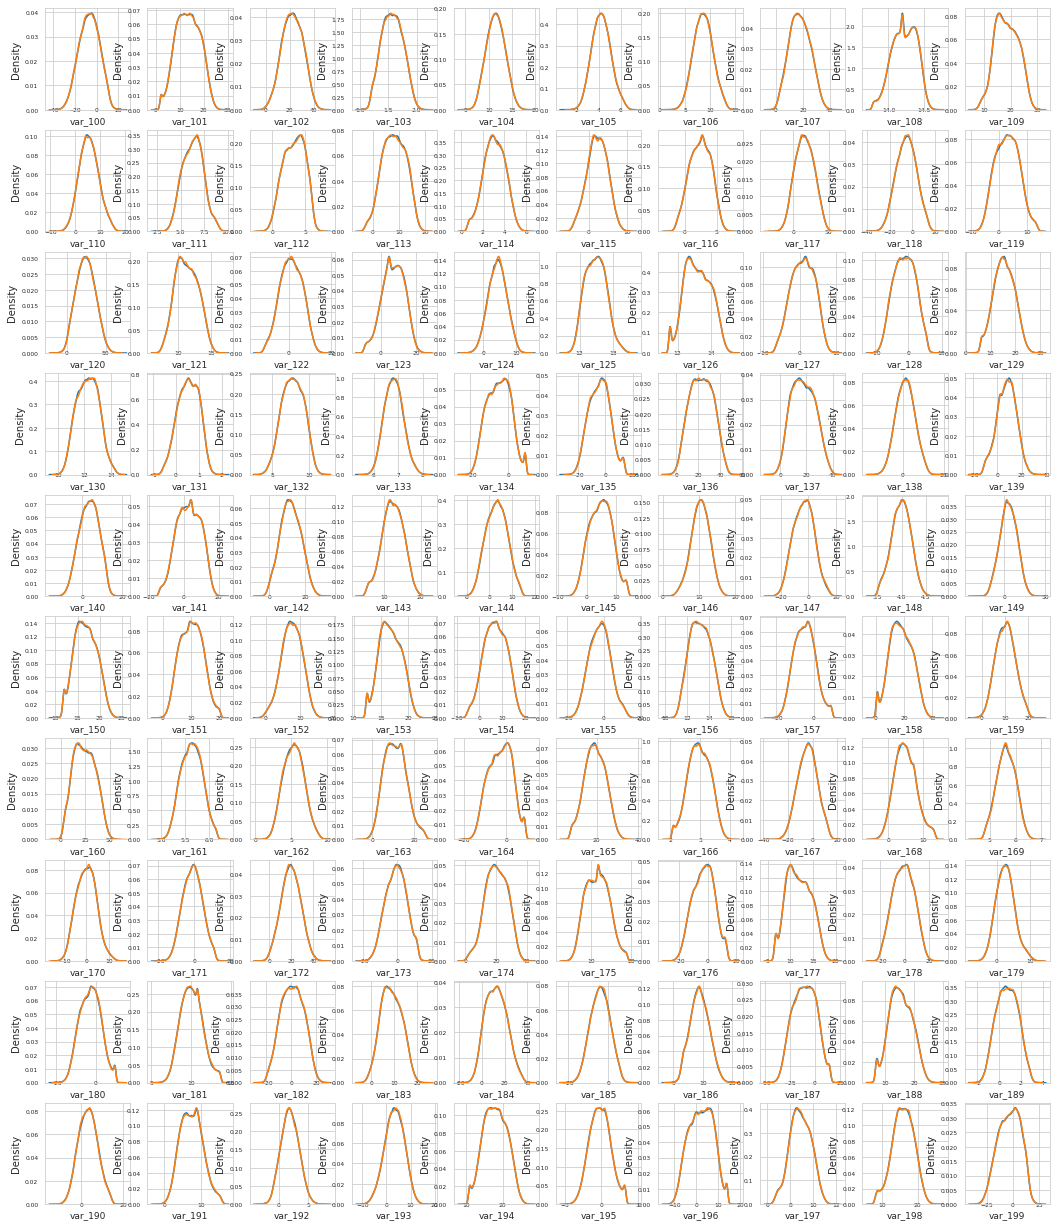

In [19]:
feature = train.columns.values[2:102]
plot_feature_distribution(train, test, 'train', 'test', features)

train / test의 target 다음 변수 100개 표시 (102:202)

<Figure size 432x288 with 0 Axes>

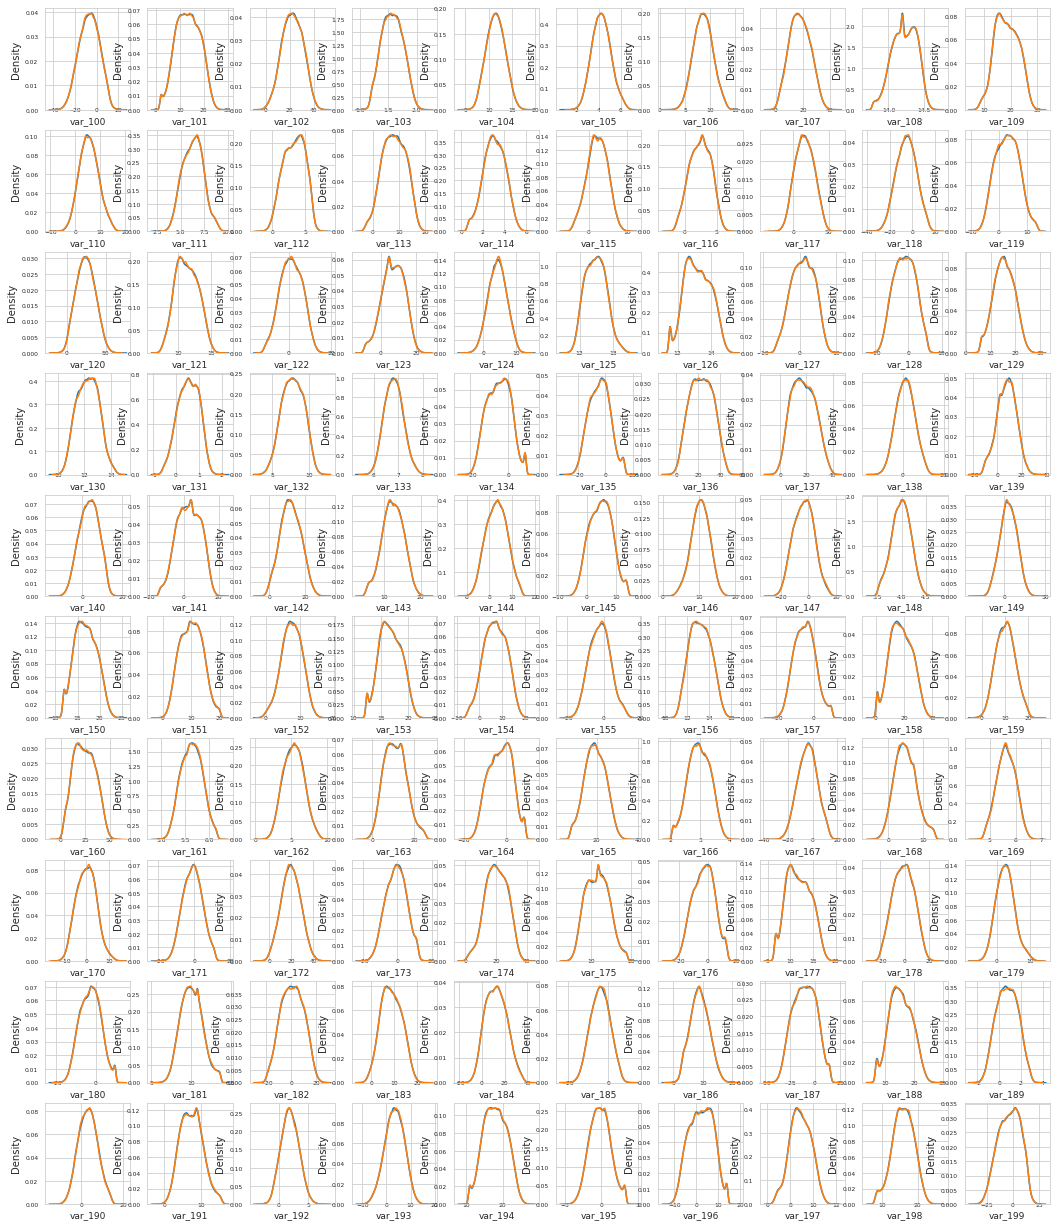

In [20]:
features = train.columns.values[102:202]
plot_feature_distribution(train, test, 'train','test', features)

위를 통해 train/test set은 수치형 변수의 분포가 균형적인 것을 볼 수 있다. 

## 3.3 Distribution of mean and std

### 3.3.1 행/열 별 평균 분포

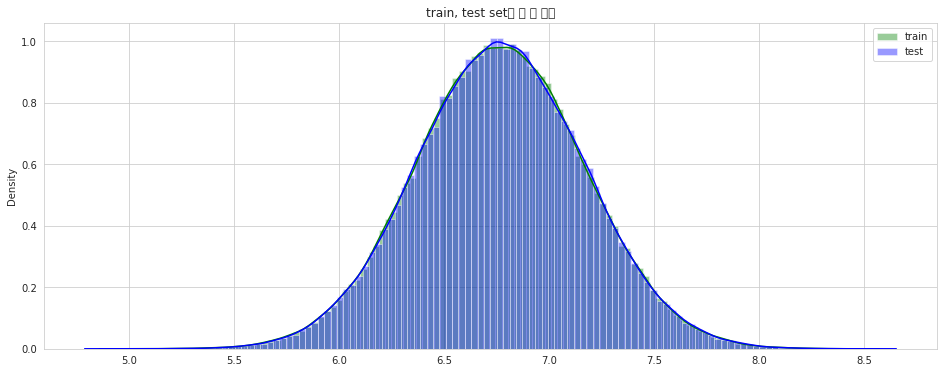

In [21]:
# 행
plt.figure(figsize=(16,6))
features=train.columns.values[2:202]

plt.title('train, test set의 행 별 평균')
sns.distplot(train[features].mean(axis=1), color='green', kde=True, bins=120, label='train')
sns.distplot(test[features].mean(axis=1), color='blue', kde=True, bins=120, label='test')

plt.legend()
plt.show()

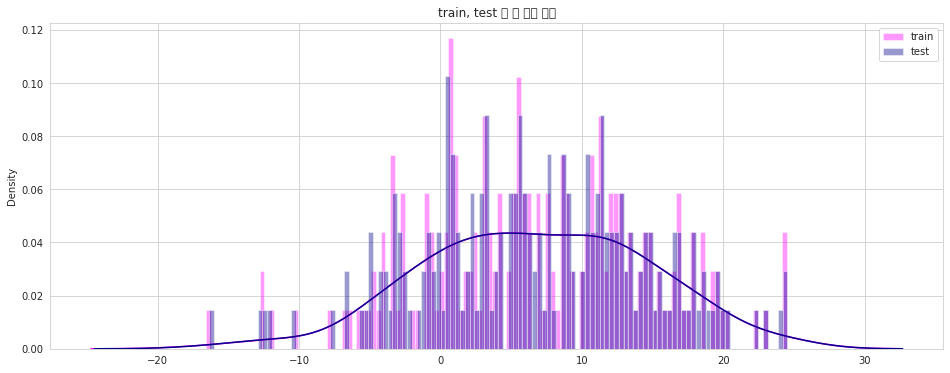

In [22]:
# 열
plt.figure(figsize=(16,6))
plt.title('train, test 열 별 평균 분포')

sns.distplot(train[features].mean(axis=0), color='magenta', kde=True, bins=120, label='train')
sns.distplot(test[features].mean(axis=0), color='darkblue', kde=True, bins=120, label='test')

plt.legend()
plt.show()

### 3.3.2 행/열 별 표준편차 분포

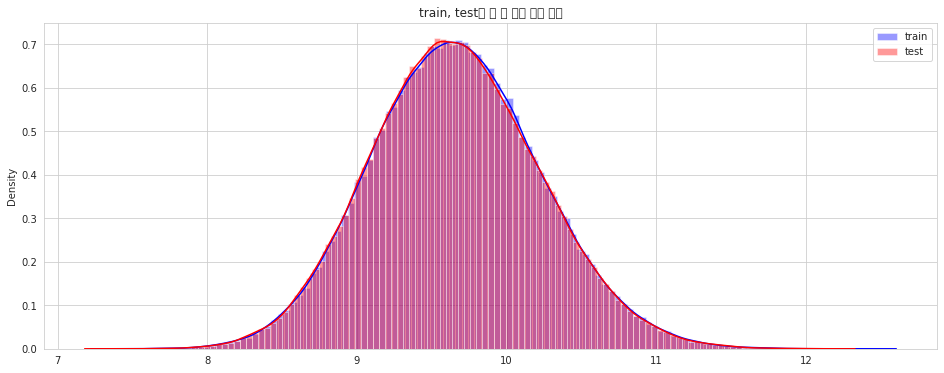

In [23]:
# 행
plt.figure(figsize=(16,6))
plt.title('train, test의 행 별 표준 편차 분포')

sns.distplot(train[features].std(axis=1), color='blue', kde=True, bins=120, label='train')
sns.distplot(test[features].std(axis=1), color='red', kde=True, bins=120, label='test')

plt.legend()
plt.show()

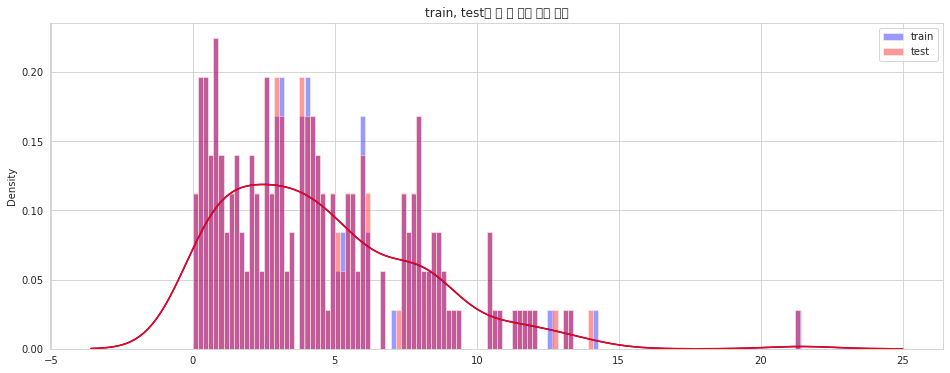

In [24]:
# 열
plt.figure(figsize=(16,6))
plt.title('train, test의 열 별 표준 편차 분포')

features=train.columns.values[2:202]
sns.distplot(train[features].std(axis=0), color='blue', kde=True, bins=120, label='train')
sns.distplot(test[features].std(axis=0), color='red', kde=True, bins=120, label='test')

plt.legend()
plt.show()

### 3.3.3 행/열 최솟값

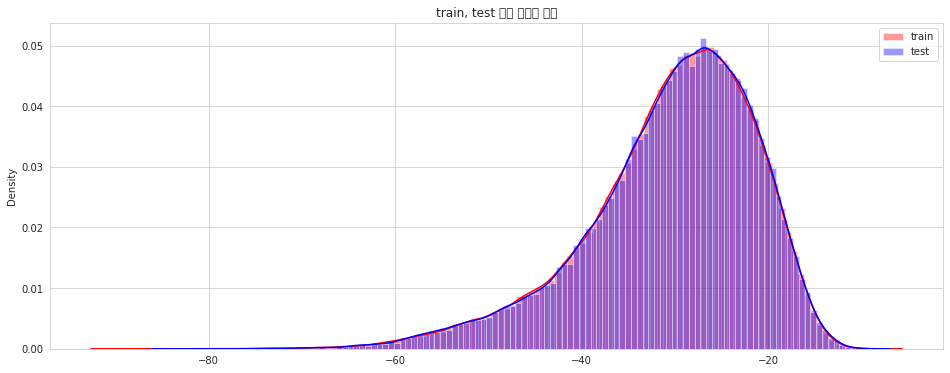

In [25]:
# 행
plt.figure(figsize=(16,6))
plt.title('train, test 행별 최솟값 분포')

featrues=train.columns.values[2:202]
sns.distplot(train[features].min(axis=1), color='red', kde=True, bins=120, label='train')
sns.distplot(test[features].min(axis=1), color='blue', kde=True, bins=120, label='test')

plt.legend()
plt.show()

train/test 세트 모두 낮은 값부터 길게 분포되어 있으며 test의 경우 -80까지 길게 늘어져 있는 것을 볼 수 있다.

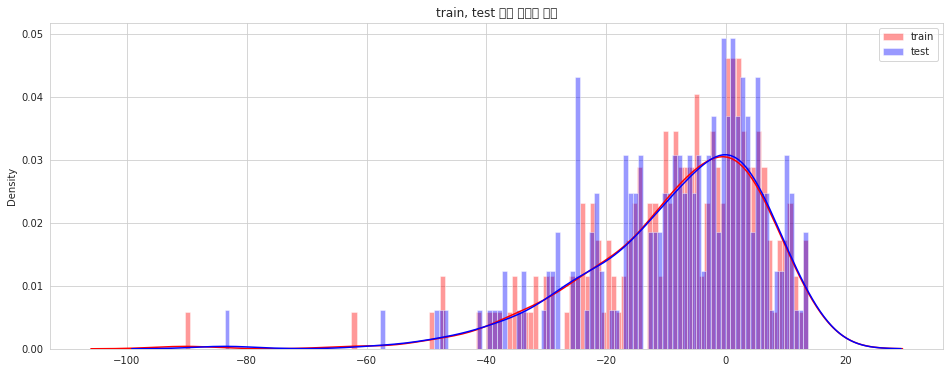

In [26]:
# 열
plt.figure(figsize=(16,6))
plt.title('train, test 열별 최솟값 분포')

features=train.columns.values[2:202]
sns.distplot(train[features].min(axis=0), color='red', kde=True, bins=120, label='train')
sns.distplot(test[features].min(axis=0), color='blue', kde=True, bins=120, label='test')

plt.legend()
plt.show()

### 3.3.4 행/열 최댓값

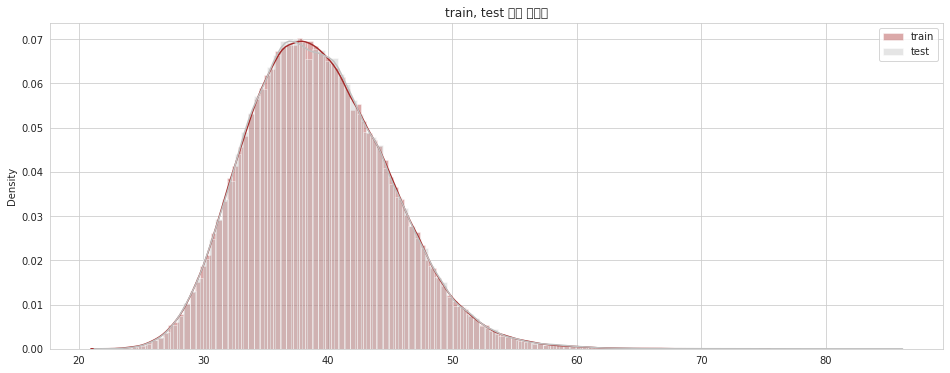

In [27]:
# 행
plt.figure(figsize=(16,6))
plt.title('train, test 행별 최댓값')

features=train.columns.values[2:202]
sns.distplot(train[features].max(axis=1), color='brown', kde=True, bins=120, label='train')
sns.distplot(test[features].max(axis=1), color='silver', kde=True, bins=120, label='test')

plt.legend()
plt.show()

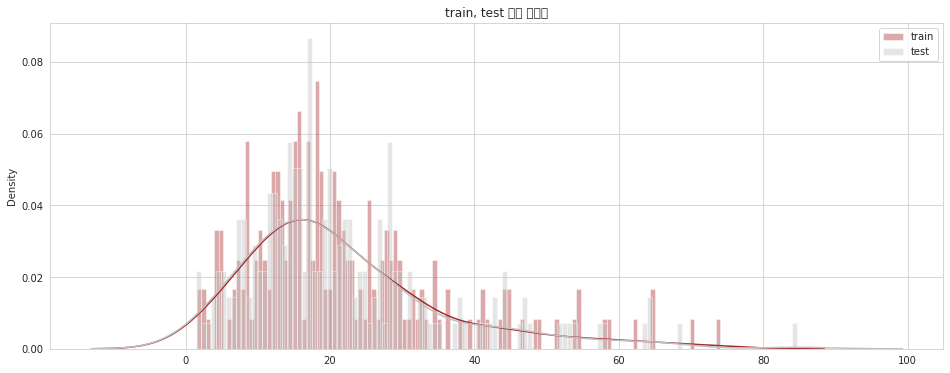

In [28]:
# 열
plt.figure(figsize=(16,6))
plt.title('train, test 열별 최댓값')

features=train.columns.values[2:202]
sns.distplot(train[features].max(axis=0), color='brown', kde=True, bins=120, label='train')
sns.distplot(test[features].max(axis=0), color='silver', kde=True, bins=120, label='test')

plt.legend()
plt.show()

### 3.3.5 Target변수 행/열 최솟값

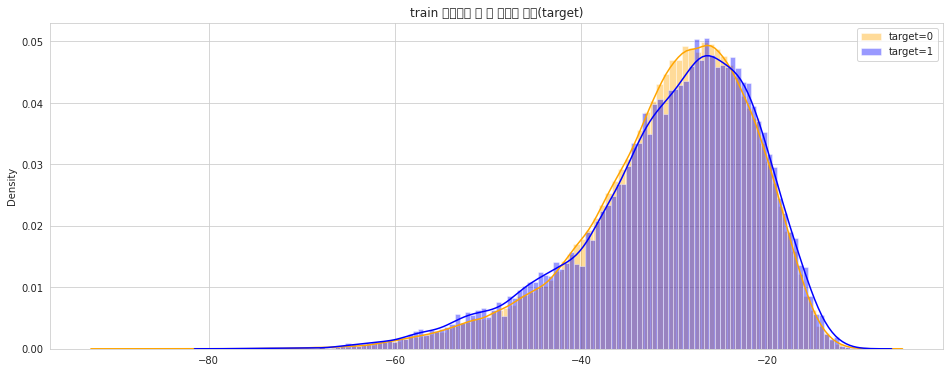

In [29]:
# 행
t0=train.loc[train['target']==0]
t1=train.loc[train['target']==1]

plt.figure(figsize=(16,6))
plt.title('train 데이터의 행 별 최솟값 분포(target)')

sns.distplot(t0[features].min(axis=1), color='orange', kde=True, bins=120, label='target=0')
sns.distplot(t1[features].min(axis=1), color='blue', kde=True, bins=120, label='target=1')
plt.legend()
plt.show()

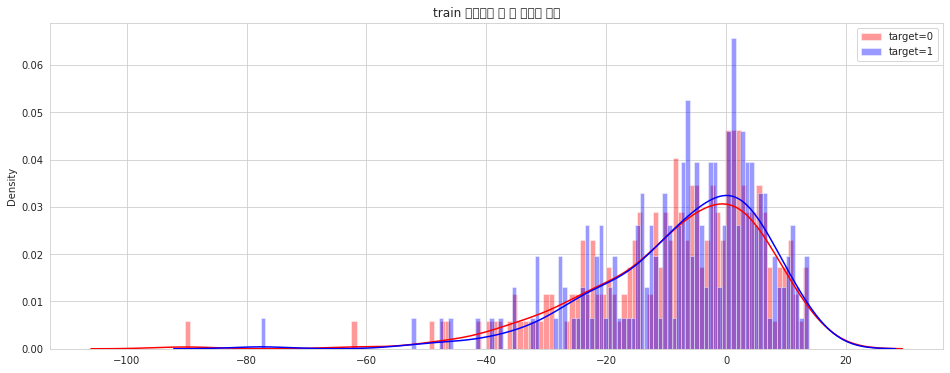

In [30]:
# 열 
t0=train.loc[train['target']==0]
t1=train.loc[train['target']==1]

plt.figure(figsize=(16,6))
plt.title('train 데이터의 열 별 최솟값 분포')
sns.distplot(t0[features].min(axis=0), color='red', kde=True, bins=120, label='target=0')
sns.distplot(t1[features].min(axis=0), color='blue', kde=True, bins=120, label='target=1')
plt.legend()
plt.show()

### 3.3.6 Target변수 행/열 최댓값

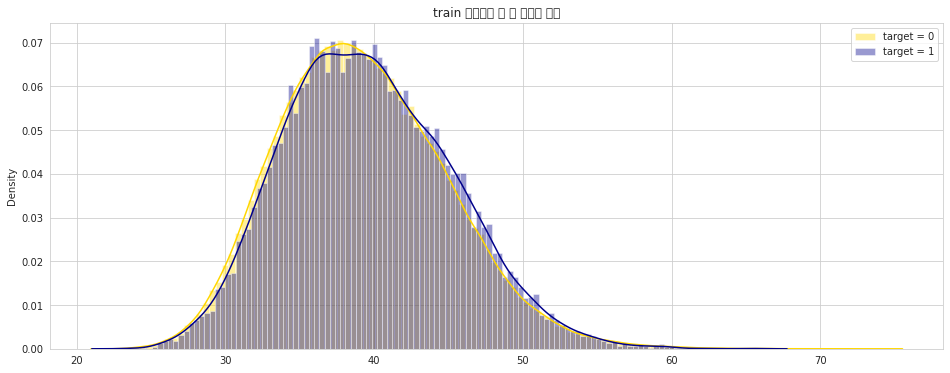

In [31]:
# 행
plt.figure(figsize=(16,6))
plt.title('train 데이터의 행 별 최댓값 분포')

sns.distplot(t0[features].max(axis=1), color='gold', kde=True, bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1), color='darkblue', kde=True, bins=120, label='target = 1')
plt.legend()
plt.show()

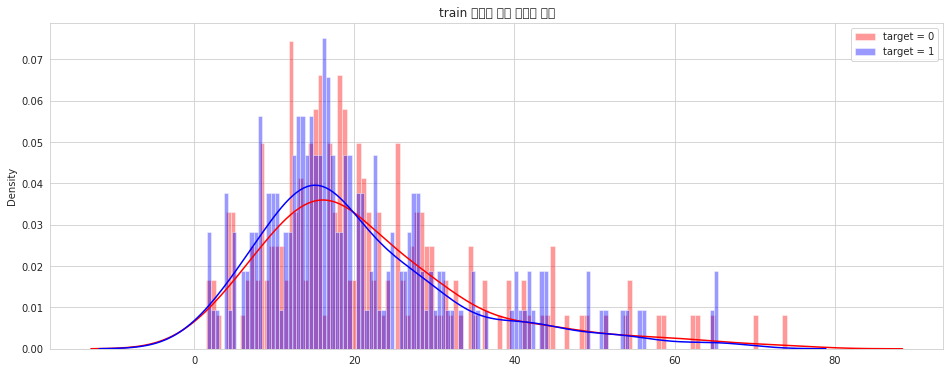

In [32]:
# 열 
plt.figure(figsize=(16,6))
plt.title("train 데이터 열별 최댓값 분포")

sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

## 3.4 Distribution of skew and Kurtosis
train, test set의 행/열 별 왜도와 첨도를 알아본다.

### 3.4.1 Skewness

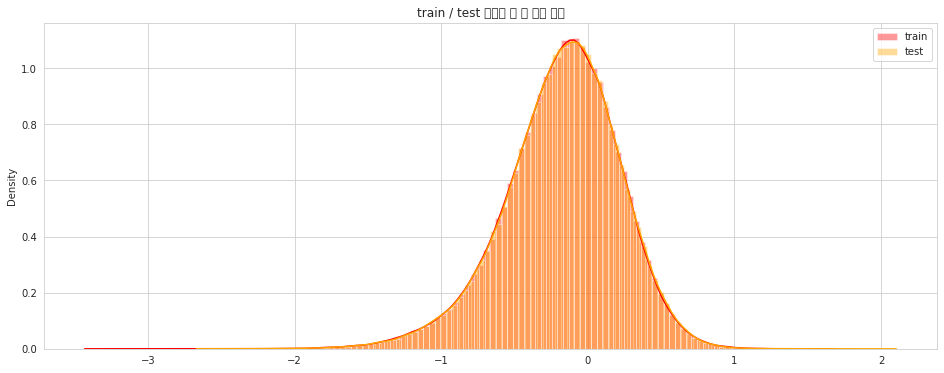

In [33]:
# 행
plt.figure(figsize=(16,6))

plt.title('train / test 데이터 행 별 왜도 분포')
sns.distplot(train[features].skew(axis=1), color='red', kde=True, bins=120, label='train')
sns.distplot(test[features].skew(axis=1), color='orange', kde=True, bins=120, label='test')
plt.legend()
plt.show()

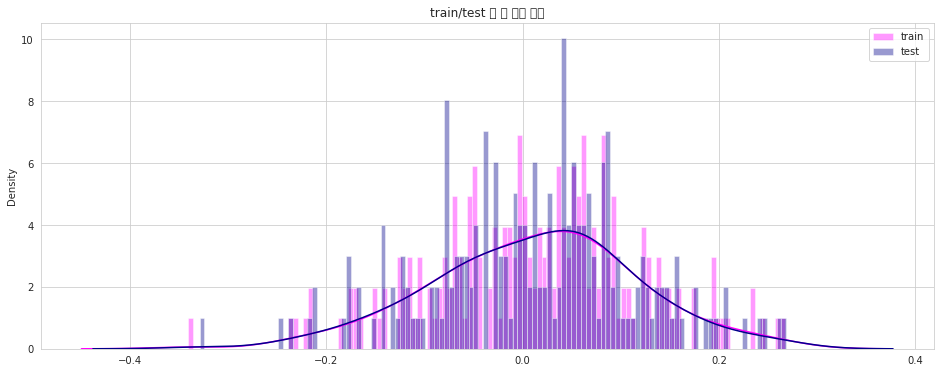

In [34]:
# 열
plt.figure(figsize=(16,6))
plt.title('train/test 열 별 왜도 분포')

sns.distplot(train[features].skew(axis=0), color='magenta', kde=True, bins=120, label='train')
sns.distplot(test[features].skew(axis=0), color='darkblue', kde=True, bins=120, label='test')
plt.legend()
plt.show()

### 3.4.2 Kurtosis

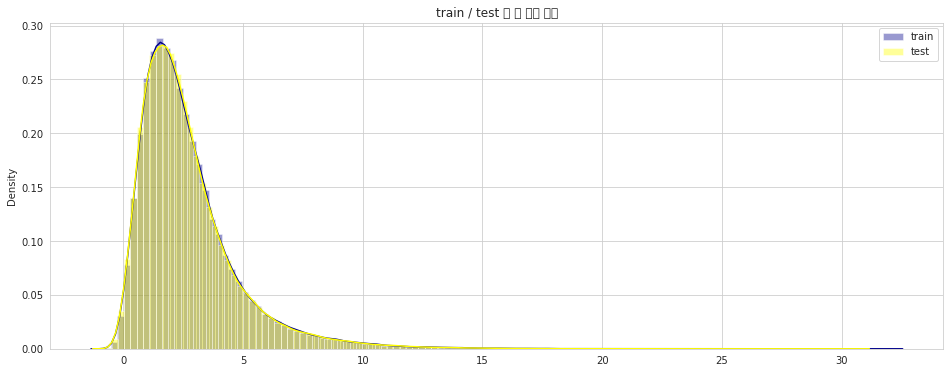

In [35]:
# 행
plt.figure(figsize=(16,6))
plt.title('train / test 행 별 첨도 분포')

sns.distplot(train[feature].kurtosis(axis=1), color='darkblue', kde=True, bins=120, label='train')
sns.distplot(test[feature].kurtosis(axis=1), color='yellow', kde=True, bins=120, label='test')
plt.legend()
plt.show()

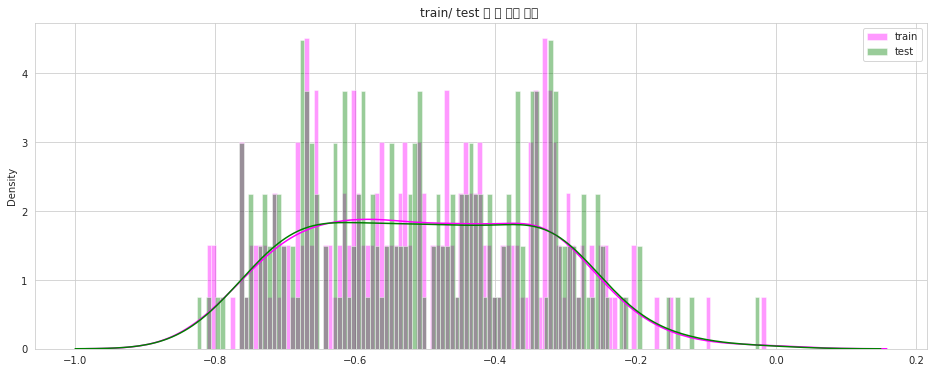

In [36]:
# 열 별 첨도
plt.figure(figsize=(16,6))
plt.title('train/ test 열 별 첨도 분포 ')

sns.distplot(train[features].kurt(axis=0), color='magenta', kde=True, bins=120, label='train')
sns.distplot(test[features].kurt(axis=0), color='green', kde=True, bins=120, label='test')
plt.legend()
plt.show()

### 3.4.3 Target값 왜도 분포

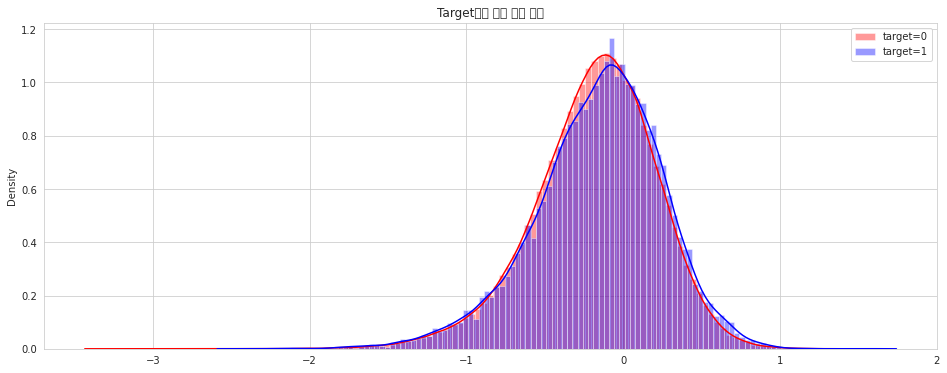

In [37]:
# 행
t0=train.loc[train['target']==0]
t1=train.loc[train['target']==1]

plt.figure(figsize=(16,6))
plt.title('Target값의 행별 왜도 분포')

sns.distplot(t0[features].skew(axis=1), color='red', kde=True, bins=120, label='target=0')
sns.distplot(t1[features].skew(axis=1), color='blue', kde=True, bins=120, label='target=1')
plt.legend()
plt.show()

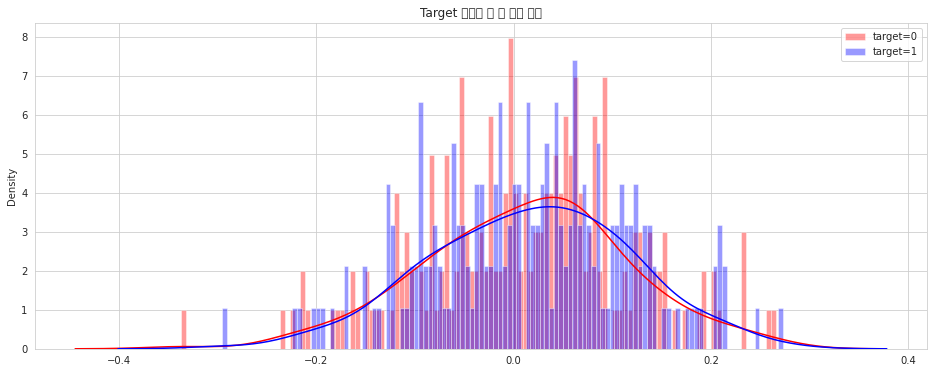

In [38]:
# 열
t0=train.loc[train['target']==0]
t1=train.loc[train['target']==1]

plt.figure(figsize=(16,6))
plt.title('Target 변수의 열 별 첨도 분포')
sns.distplot(t0[features].skew(axis=0), color='red', kde=True, bins=120, label='target=0')
sns.distplot(t1[features].skew(axis=0), color='blue', kde=True, bins=120, label='target=1')
plt.legend()
plt.show()

### 3.4.5 Target값 첨도 분포

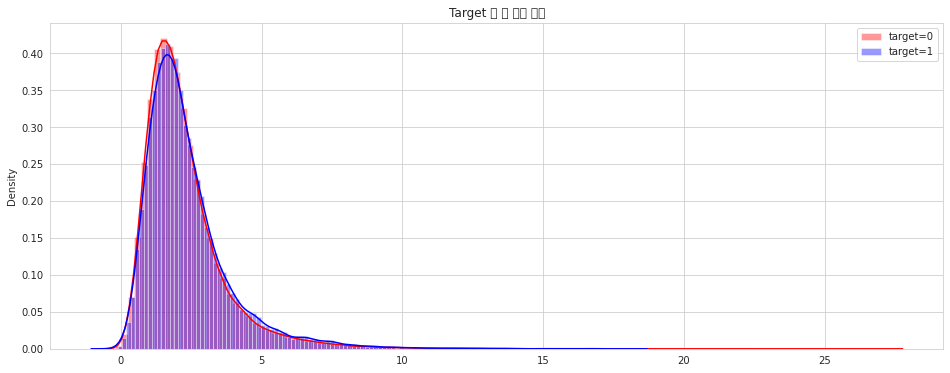

In [39]:
# 행
t0=train.loc[train['target']==0]
t1=train.loc[train['target']==1]

plt.figure(figsize=(16,6))
plt.title('Target 행 별 첨도 분포')
sns.distplot(t0[features].kurtosis(axis=1), color='red', kde=True, bins=120, label='target=0')
sns.distplot(t1[features].kurtosis(axis=1), color='blue', kde=True, bins=120, label='target=1')
plt.legend()
plt.show()

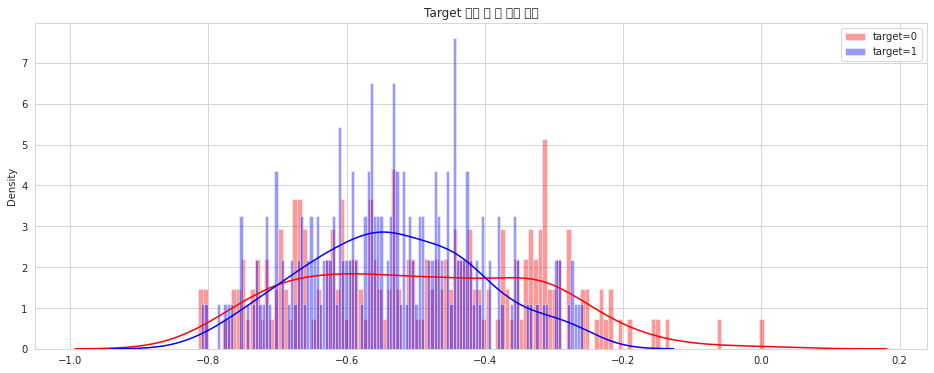

In [40]:
# 열
t0 = train.loc[train['target']==0]
t1 = train.loc[train['target']==1]

plt.figure(figsize=(16,6))
plt.title('Target 변수 열 별 첨도 분포')
sns.distplot(t0[features].kurtosis(axis=0), color='red', kde=True, bins=120, label='target=0')
sns.distplot(t1[features].kurtosis(axis=0), color='blue', kde=True, bins=120, label='target=1')
plt.legend()
plt.show()

## 3.5 Feature Corrleation

train 변수들 간 상관관계를 계산한다.  
하단의 표는 상관 관계가 가장 적은 하위 10개의 변수를 보여준다.


In [41]:
%%time
corr = train[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
corr = corr[corr['level_0'] != corr['level_1']]
corr.head(10)

CPU times: user 17.9 s, sys: 19.1 ms, total: 18 s
Wall time: 17.8 s


동일한 변수 쌍을 제외하고 가장 상관관계가 높은 변수에 대해 살펴본다.

In [42]:
corr.tail(10)  # 상관관계 상위 10개 변수

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


In [43]:
corr.head(10) # 상관관계 하위 10개 변수

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


## 3.6 Duplicate values
열에 얼마나 많은 중복값이 있는지 확인한다. 

In [44]:
features=train.columns.values[2:202]
unique_max_train=[]
unique_max_test=[]

for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

train set에서 중복이 많은 상위 15개 변수 확인

In [45]:
np.transpose((pd.DataFrame(unique_max_train,
                           columns=['Feature', 'Max duplicate', 'Value']).sort_values(by='Max duplicate', ascending=False).head(15)))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicate,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


test set에서 중복이 많은 상위 15개 변수 확인

In [46]:
np.transpose((pd.DataFrame(unique_max_test,
                           columns=['Feature', 'Max duplicate', 'Value']).sort_values(by='Max duplicate', ascending=False).head(15)))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicate,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


# 4.Feature Engineering
---
기존 변수에 대해 몇가지 집계를 시행한다.

In [47]:
%%time 
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurt(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 10.4 s, sys: 359 ms, total: 10.7 s
Wall time: 10.7 s


새로 생성한 변수 확인.

In [48]:
train[train.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [49]:
test[test.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [50]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4, figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5, label=label1)
        sns.kdeplot(df2[feature], bw=0.5, label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, label= plt.xticks()

        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()

새로 생성한 변수의 분포를 확인하고 가공한다.  
Target값에 따라(0,1) 그룹화된 새로운 특징의 분포를 그림으로 표시한다. 

<Figure size 432x288 with 0 Axes>

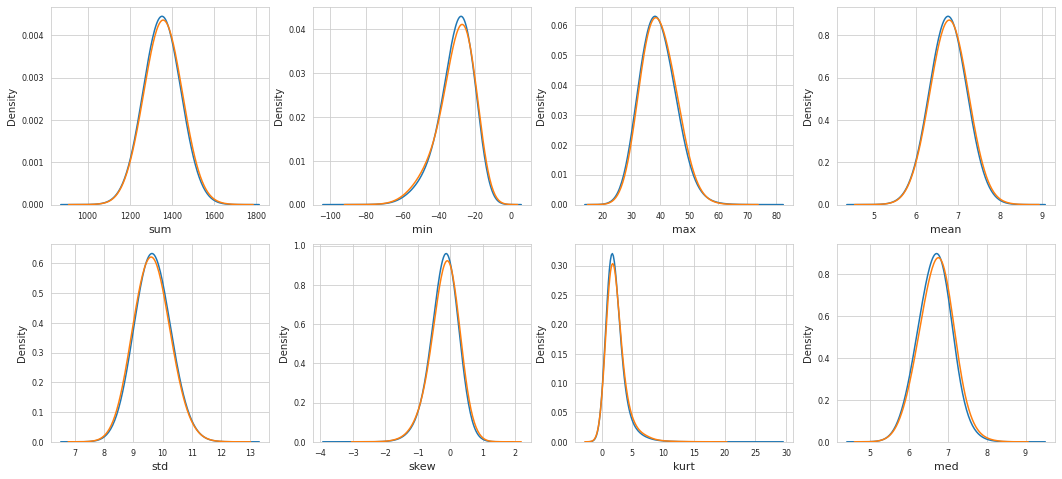

In [51]:
# train - target기준
t0 = train.loc[train['target']==0]
t1 = train.loc[train['target']==1]

features = train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target:0',' target:1', features)

train / test의 새로 생성한 변수 분포 확인.

<Figure size 432x288 with 0 Axes>

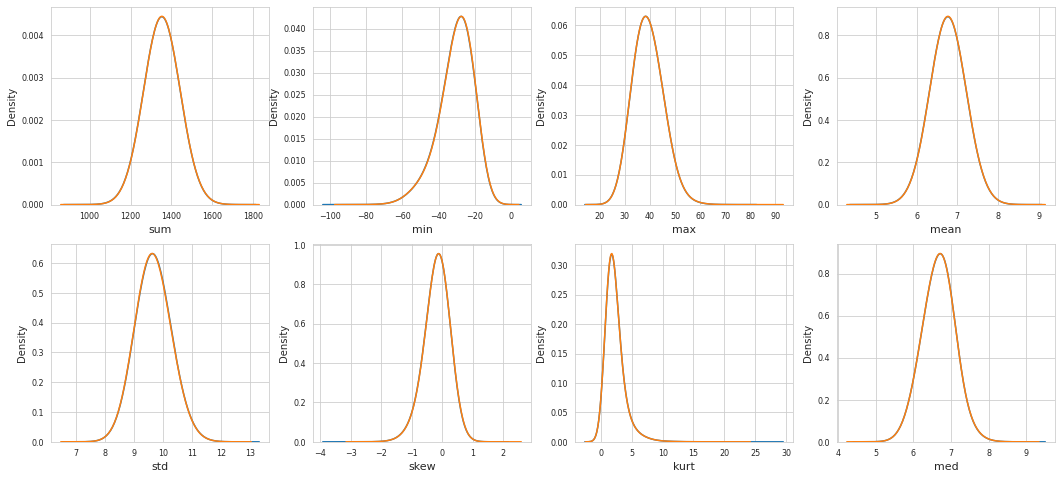

In [52]:
# train / test
features=train.columns.values[202:]
plot_new_feature_distribution(train, test, 'train',' test', features)

In [53]:
# 반올림 변수 (사용X)

# features = [c for c in train.columns if c not in ['ID_code','target']]

# for feature in features:
#     train['r2_'+feature] = np.round(train[feature],2)
#     test['r2_'+feature] = np.round(test[feature],2)
#     train['r1_'+feature] = np.round(train[feature],1)
#     test['r1_'+feature] = np.round(test[feature],1)

# # 얼마나 많은 변수르 가지고 있는지 확인해본다.
# print(f"train and test columns : {len(train.columns)} {len(test.columns)}")

위 셀 수행 결과 성능이 저하됨으로 사용하지 않는다. 

반올림에 대한 문의

        [질문]
        Why are we doubling the features of the dataset with just a rounded version of the original value? What is the statistical usefulness of the operation?
        원래 값의 반올림 버전만으로 데이터 세트의 기능을 두 배로 늘리는 이유는 무엇입니까? 이 작업의 통계상 유용성은 무엇입니까?

        [답변]
        Someone had a similar question lower down in the thread (Post by Srikanth), where Gabriel had said that "I tried it as a simple ad-hoc technique to verify if by removing a bit of the precision I get less overfitting."
        가브리엘이 "나는 약간의 정밀도를 제거함으로써 과적합이 덜 되는지 검증하기 위해 간단한 애드혹 기법으로 그것을 시도했다."라고 말한 스리칸스(Post by Srikanth) 아래에 비슷한 질문이 있었다.
        

# 5.Model
---


## 5.1 일부 변수 제거


In [54]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target=train['target']

## 5.2 모델 하이퍼파라미터 정의

In [55]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

## 5.3 모델링



In [59]:
%%time
folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=44000)
oof=np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df=pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print(f"Fold {fold_}")
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000 # 2회차-10000으로 시도
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['importance'] = clf.feature_importance()
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration)/folds.n_splits
    
print('CV score : {:<8.5f}'.format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.899868	valid_1's auc: 0.887297
[2000]	training's auc: 0.911064	valid_1's auc: 0.894514
[3000]	training's auc: 0.918606	valid_1's auc: 0.8984
[4000]	training's auc: 0.924571	valid_1's auc: 0.900259
[5000]	training's auc: 0.929481	valid_1's auc: 0.901064
[6000]	training's auc: 0.933833	valid_1's auc: 0.901606
[7000]	training's auc: 0.937749	valid_1's auc: 0.901984
[8000]	training's auc: 0.941447	valid_1's auc: 0.901914
[9000]	training's auc: 0.945015	valid_1's auc: 0.901855
[10000]	training's auc: 0.948367	valid_1's auc: 0.901761
Early stopping, best iteration is:
[7480]	training's auc: 0.939553	valid_1's auc: 0.902057
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900243	valid_1's auc: 0.880051
[2000]	training's auc: 0.911119	valid_1's auc: 0.888823
[3000]	training's auc: 0.91872	valid_1's auc: 0.893517
[4000]	training's auc: 0.924627	valid_1's

## 5.4 Feature Importance

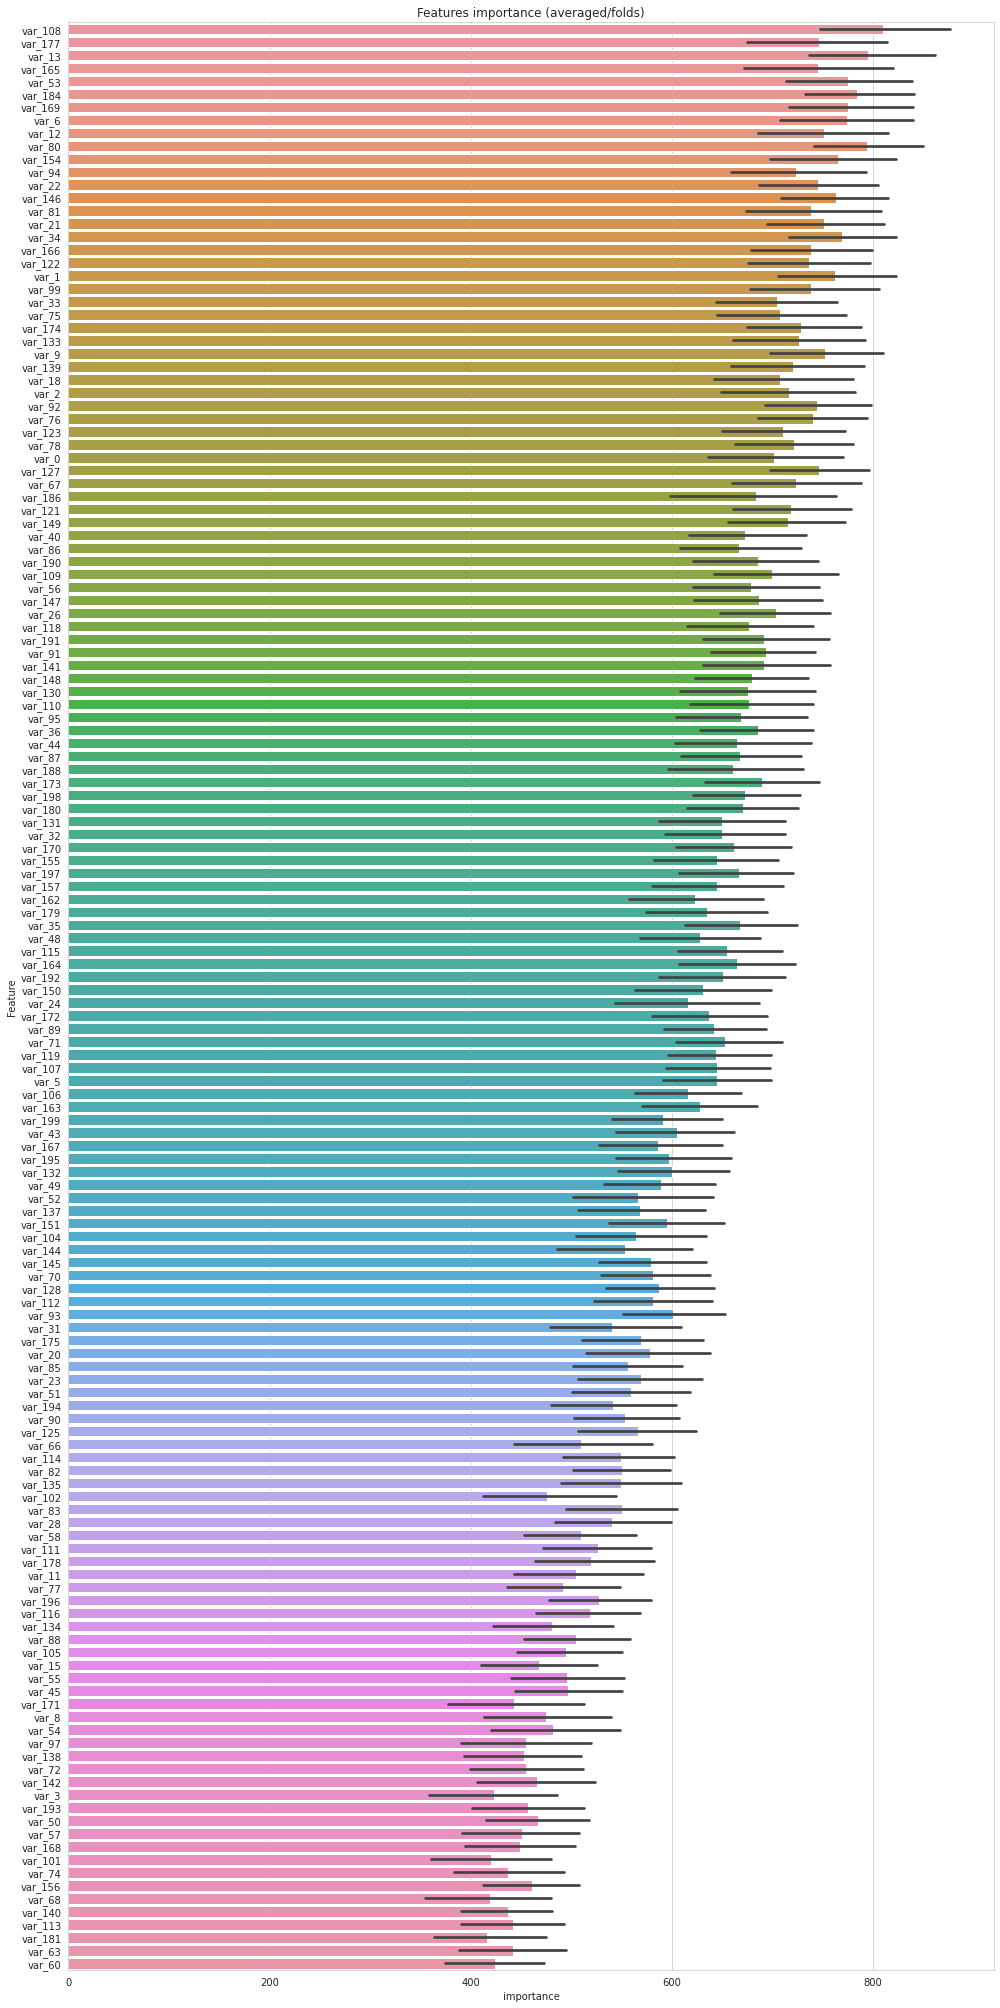

In [62]:
cols = (feature_importance_df[['Feature', 'importance']]).groupby('Feature').mean().sort_values(by='importance', ascending=False)[:150].index
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x='importance', y='Feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

# 6.Submission
---


In [65]:
sub_df=pd.DataFrame({'ID_code':test['ID_codes'].values, 'target':predictions})
# sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})

KeyError: ignored

# 7. References


[1] https://www.kaggle.com/gpreda/elo-world-high-score-without-blending  
[2] https://www.kaggle.com/chocozzz/santander-lightgbm-baseline-lb-0-897  
[3] https://www.kaggle.com/brandenkmurray/nothing-works